In [2]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
from importlib import reload

In [3]:
import preprocessing
import model
from preprocessing import *
from model import *

In [6]:
#BG
filename_bg = 'background_for_training.h5'
batch_size = 128
nodes_n, feat_sz, particles_bg, A_bg, A_tilde_bg = prepare_data(filename_bg,0,batch_size*20)

/eos/home-n/nchernya/MLHEP/mpp_tutorials/ADC2021-examplecode/preprocessing.py:20: RuntimeWarning: divide by zero encountered in power
  D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))


In [7]:
print(particles_bg.shape, A_tilde_bg.shape, A_bg.shape)

(2560, 19, 4) (2560, 19, 19) (2560, 19, 19)


# Autoencoder

In [6]:
gnn = GraphAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 19, 4)]      0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 19, 19)]     0                                            
__________________________________________________________________________________________________
graph_convolution (GraphConvolu (None, 19, 6)        54          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_1 (GraphConvo (None, 19, 8)        104         graph_convolution[0][0

In [7]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)]
gnn.fit((particles_bg, A_tilde_bg), A_bg, epochs=100, batch_size=128, validation_split=0.25, callbacks=callbacks)

Epoch 1/100
15/15 [==============================] - 1s 38ms/step - val_loss: 0.6808
Epoch 2/100
15/15 [==============================] - 1s 40ms/step - val_loss: 0.6862
Epoch 3/100
15/15 [==============================] - 1s 34ms/step - val_loss: 0.6743
Epoch 4/100
15/15 [==============================] - 0s 33ms/step - val_loss: 0.6746
Epoch 5/100
15/15 [==============================] - 1s 37ms/step - val_loss: 0.6738
Epoch 6/100
15/15 [==============================] - 0s 31ms/step - val_loss: 0.6736
Epoch 7/100
15/15 [==============================] - 0s 30ms/step - val_loss: 0.6735
Epoch 8/100
15/15 [==============================] - 0s 31ms/step - val_loss: 0.6732
Epoch 9/100
15/15 [==============================] - 0s 32ms/step - val_loss: 0.6729
Epoch 10/100
15/15 [==============================] - 1s 34ms/step - val_loss: 0.6724
Epoch 11/100
15/15 [==============================] - 0s 31ms/step - val_loss: 0.6716
Epoch 12/100
15/15 [==============================] - 0s 30ms/s

## Predict BG and Sig

In [12]:
z_sig, A_pred_sig = gnn((particles_sig, A_tilde_sig))
z_bg, A_pred_bg = gnn((particles_bg, A_tilde_bg))
loss_signal = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_sig, A_pred_sig), axis=(1,2)).numpy()
loss_bg = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_bg, A_pred_bg), axis=(1,2)).numpy()

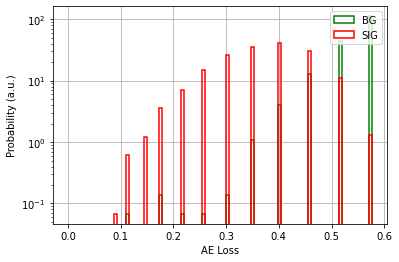

In [14]:
max_score = np.max(np.max(loss_bg))#,np.max(loss_bg_dist))
# plot BG
plt.figure()
plt.hist(loss_bg, bins=100, label='BG', density=True, range=(0, max_score), 
         histtype='step', fill=False, linewidth=1.5,color='g')
plt.hist(loss_signal, bins=100, label='SIG', density=True, range=(0, max_score), 
         histtype='step', fill=False, linewidth=1.5,color='r')
plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Trying GCN VAE

In [8]:
def threeD_loss_manual(inputs, outputs):
    distances = np.sum(np.subtract(inputs[:,:,np.newaxis,:],outputs[:,np.newaxis,:,:])**2, axis=-1)
    min_dist_to_inputs = np.min(distances,axis=1)
    min_dist_to_outputs = np.min(distances,axis=2)
    return np.sum(min_dist_to_inputs,axis=1) + np.sum(min_dist_to_outputs,axis=1)



In [9]:
from importlib import reload
import model
reload(model)
from model import *
gcnvae = GCNVariationalAutoEncoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gcnvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 19, 4)]      0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 19, 19)]     0                                            
__________________________________________________________________________________________________
graph_convolution (GraphConvolu (None, 19, 3)        27          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_1 (GraphConvo (None, 19, 2)        14          graph_convolution[0][0

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input_latent_space (Inp [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 19)           209         decoder_input_latent_space[0][0] 
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 38)           760         dense_6[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 19, 2)        0           dense_7[0][0]                    
_______________________________________________________________________________________

In [10]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)]
gcnvae.fit(particles_bg, A_bg, epochs=100, batch_size=128,callbacks=callbacks) # validation_split=0.25, 

Epoch 1/100
20/20 [==============================] - 1s 60ms/step - loss: 3.0622 - loss_reco: 3.0499 - loss_latent: 0.0123
Epoch 2/100
20/20 [==============================] - 1s 50ms/step - loss: 2.4927 - loss_reco: 2.4911 - loss_latent: 0.0016
Epoch 3/100
20/20 [==============================] - 1s 50ms/step - loss: 2.3778 - loss_reco: 2.3769 - loss_latent: 9.2517e-04
Epoch 4/100
20/20 [==============================] - 1s 57ms/step - loss: 2.3338 - loss_reco: 2.3329 - loss_latent: 9.3111e-04
Epoch 5/100
20/20 [==============================] - 1s 56ms/step - loss: 2.2990 - loss_reco: 2.2979 - loss_latent: 0.0011
Epoch 6/100
20/20 [==============================] - 1s 52ms/step - loss: 2.2634 - loss_reco: 2.2629 - loss_latent: 4.6073e-04
Epoch 7/100
20/20 [==============================] - 1s 55ms/step - loss: 2.2357 - loss_reco: 2.2352 - loss_latent: 5.0313e-04
Epoch 8/100
20/20 [==============================] - 1s 56ms/step - loss: 2.2469 - loss_reco: 2.2466 - loss_latent: 3.6315e

20/20 [==============================] - 1s 54ms/step - loss: 2.1889 - loss_reco: 2.1889 - loss_latent: 3.2897e-07
Epoch 44/100
20/20 [==============================] - 1s 58ms/step - loss: 2.1994 - loss_reco: 2.1994 - loss_latent: 2.2712e-07
Epoch 45/100
20/20 [==============================] - 1s 58ms/step - loss: 2.1893 - loss_reco: 2.1893 - loss_latent: 6.0118e-07
Epoch 46/100
20/20 [==============================] - 1s 53ms/step - loss: 2.1962 - loss_reco: 2.1962 - loss_latent: 2.0075e-07
Epoch 47/100
20/20 [==============================] - 1s 57ms/step - loss: 2.1997 - loss_reco: 2.1997 - loss_latent: 6.2835e-08
Epoch 48/100
20/20 [==============================] - 1s 53ms/step - loss: 2.1964 - loss_reco: 2.1964 - loss_latent: 6.4823e-08
Epoch 49/100
20/20 [==============================] - 1s 50ms/step - loss: 2.1725 - loss_reco: 2.1725 - loss_latent: 2.8383e-08
Epoch 50/100
20/20 [==============================] - 1s 56ms/step - loss: 2.1952 - loss_reco: 2.1952 - loss_latent: 

20/20 [==============================] - 1s 42ms/step - loss: 2.1851 - loss_reco: 2.1851 - loss_latent: 1.5838e-07
Epoch 86/100
20/20 [==============================] - 1s 40ms/step - loss: 2.1773 - loss_reco: 2.1773 - loss_latent: 2.7844e-07
Epoch 87/100
20/20 [==============================] - 1s 39ms/step - loss: 2.1848 - loss_reco: 2.1848 - loss_latent: 4.2660e-07
Epoch 88/100
20/20 [==============================] - 1s 40ms/step - loss: 2.1958 - loss_reco: 2.1958 - loss_latent: 2.5059e-05
Epoch 89/100
20/20 [==============================] - 1s 39ms/step - loss: 2.1801 - loss_reco: 2.1801 - loss_latent: 1.1571e-05
Epoch 90/100
20/20 [==============================] - 1s 38ms/step - loss: 2.1877 - loss_reco: 2.1877 - loss_latent: 2.2492e-06
Epoch 91/100
20/20 [==============================] - 1s 35ms/step - loss: 2.1802 - loss_reco: 2.1802 - loss_latent: 8.8030e-07
Epoch 92/100
20/20 [==============================] - 1s 35ms/step - loss: 2.1825 - loss_reco: 2.1825 - loss_latent: 

In [11]:
#background

In [12]:
_,_, particles_bg_test, A_bg_test, A_tilde_bg_test = prepare_data(filename_bg,3000,4000)
features_out_bg_test, z_bg_test, z_mean_bg_test, z_log_var_bg_test = gcnvae((particles_bg_test, A_bg_test))
features_out_bg_test = features_out_bg_test.numpy().astype('float32')
loss_bg = threeD_loss(particles_bg_test.astype('float32'),features_out_bg_test).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [13]:
#signal
#filename_sig = 'Ato4l_lepFilter_13TeV.h5'
#filename_sig='leptoquark_LOWMASS_lepFilter_13TeV.h5'
filename_sig = 'hToTauTau_13TeV_PU20.h5'
nodes_n, feat_sz, particles_sig, A_sig, A_tilde_sig = prepare_data(filename_sig)

features_out_sig, z_sig, z_mean_sig, z_log_var_sig = gcnvae((particles_sig, A_sig))
features_out_sig = features_out_sig.numpy().astype('float32')
loss_signal = threeD_loss(particles_sig.astype('float32'),features_out_sig).numpy()

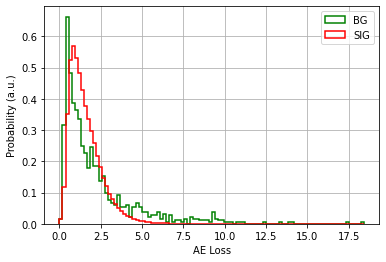

In [15]:
max_score = np.max(np.max(loss_bg))#,np.max(loss_bg_dist))
# plot BG
plt.figure()
plt.hist(loss_bg, bins=100, label='BG', density=True, range=(0, max_score), 
         histtype='step', fill=False, linewidth=1.5,color='g')
plt.hist(loss_signal, bins=100, label='SIG', density=True, range=(0, max_score), 
         histtype='step', fill=False, linewidth=1.5,color='r')
#plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [16]:
loss_signal.mean()

1.5611715

In [17]:
loss_bg.mean()

2.1979175